In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.ndimage import gaussian_filter1d
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score, brier_score_loss
from sklearn.metrics import precision_score, recall_score, f1_score

In [78]:
lead_times = ["t1", "t2", "t4", "t6"]
base_dir = "/gws/nopw/j04/wiser_ewsa/mrakotomanga/Intercomparison/time_series"

nflics = {lt: pd.read_csv(f"{base_dir}/nflics/{lt}/zambia_nowcasts_{lt}.csv") for lt in lead_times}
netncc = {lt: pd.read_csv(f"{base_dir}/netncc/{lt}/zambia_nowcasts_{lt}.csv") for lt in lead_times}

cities = [col.replace("_t1", "") for col in nflics["t1"].columns if col.endswith("_t1")]

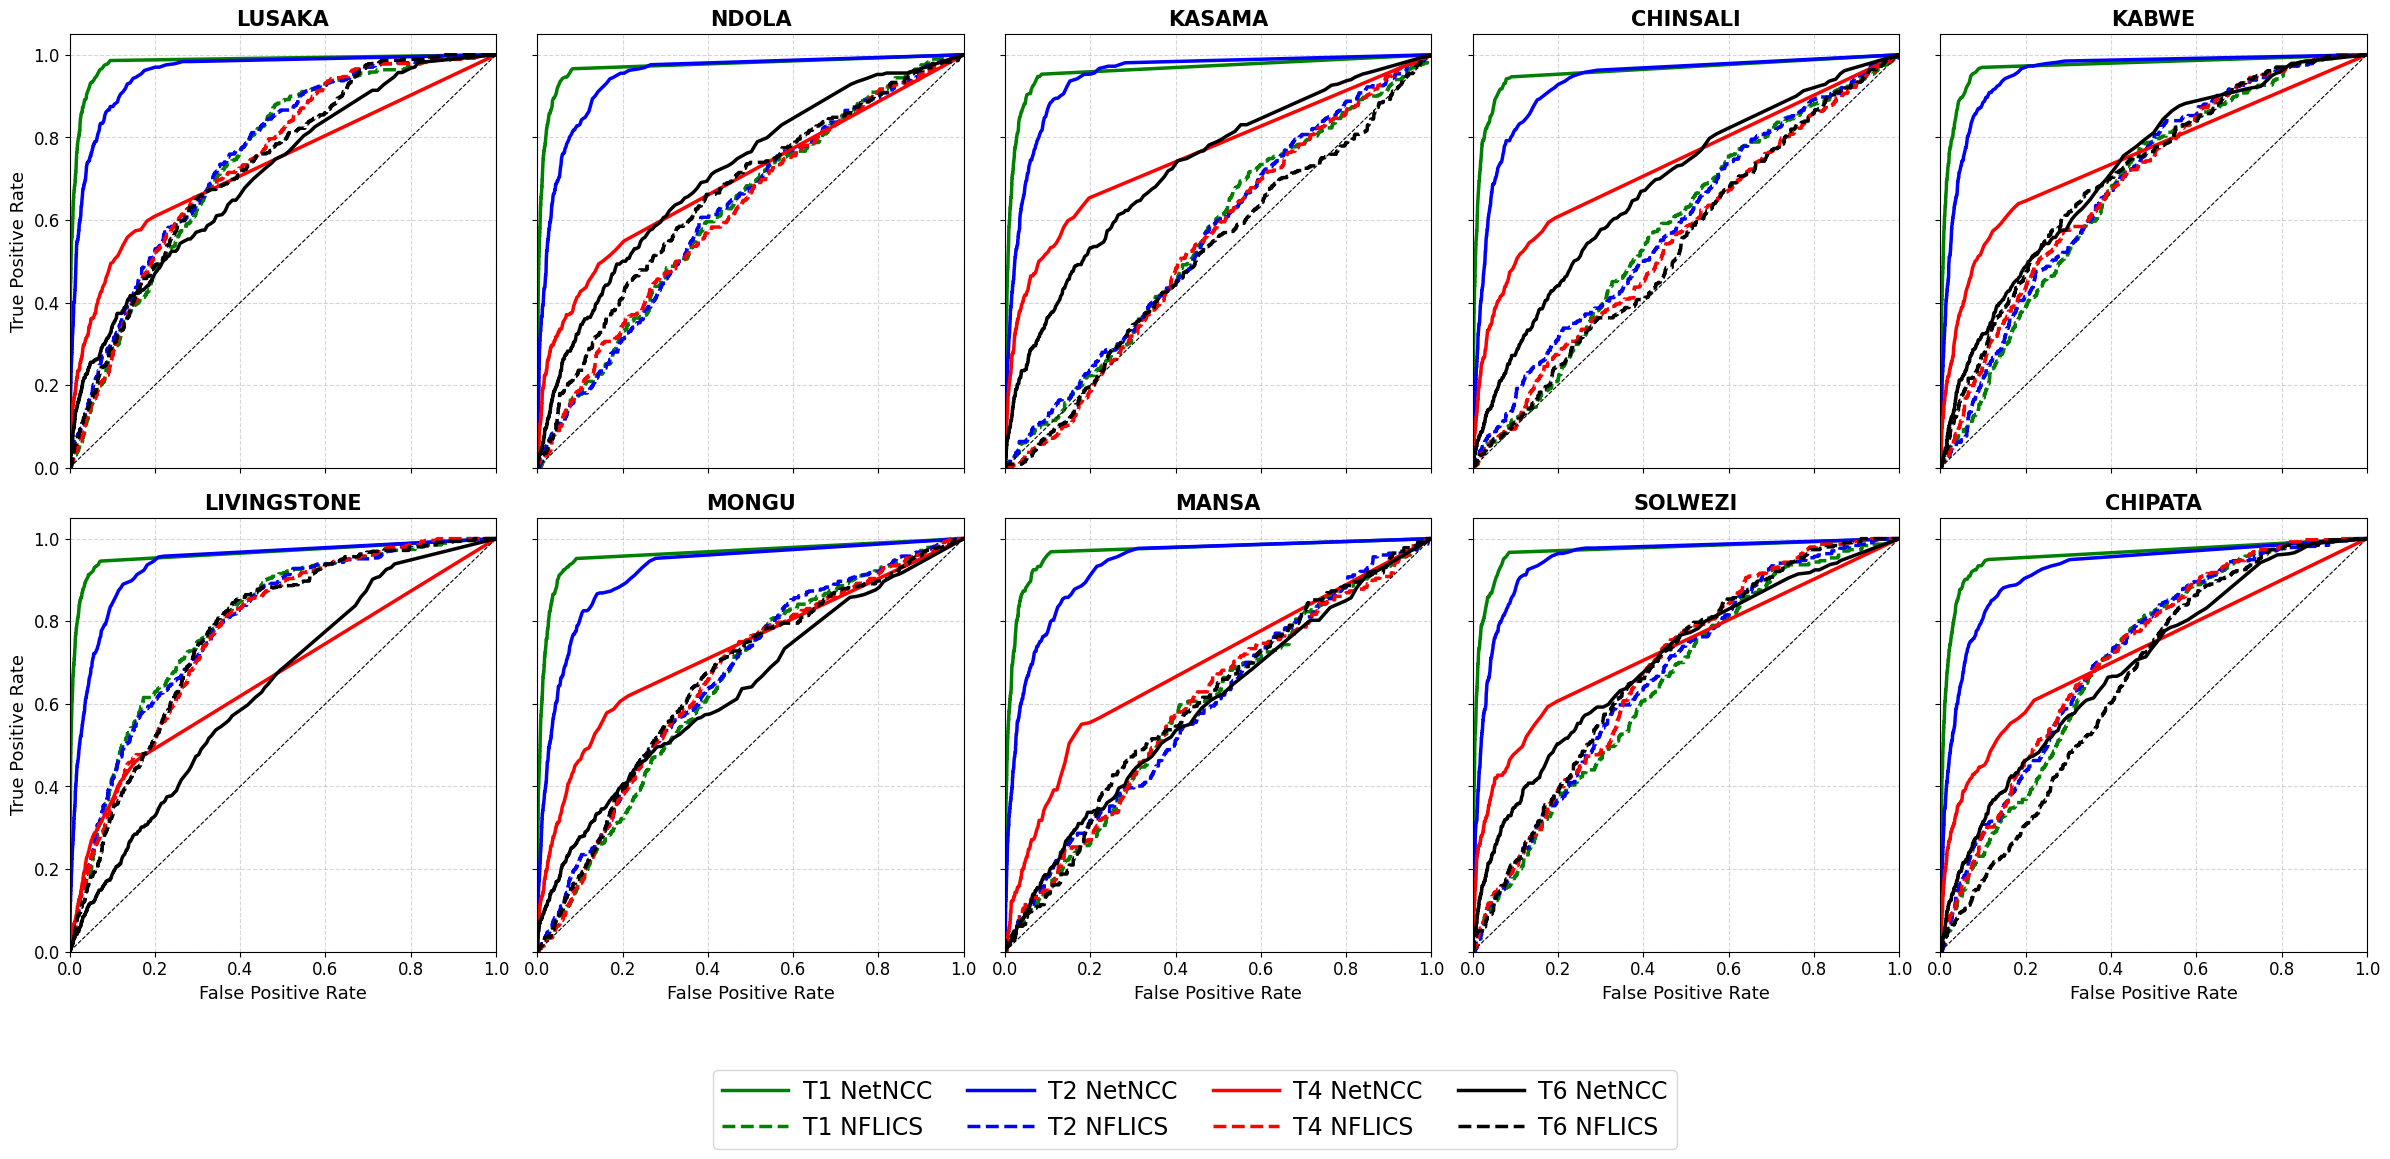

In [ ]:
# Create figure with high DPI
fig, axes = plt.subplots(2, 5, figsize=(24, 11))
axes = axes.flatten()

# Custom colour mapping
colors = {"t1": "green", "t2": "blue", "t4": "red", "t6": "black"}
handles_all, labels_all = [], []

for i, city in enumerate(cities[:10]):
    ax = axes[i]

    for lt in lead_times:
        df_nf = nflics[lt]
        df_nc = netncc[lt]
        gt_col = f"{city}_gt_lt{lt[-1]}"
        if gt_col not in df_nf.columns or f"{city}_{lt}" not in df_nc.columns:
            continue

        # Align timestamps between products
        merged = pd.merge(
            df_nf[["t0", gt_col, f"{city}_{lt}"]],
            df_nc[["t0", f"{city}_{lt}"]],
            on="t0",
            suffixes=("_nfl", "_ncc")
        )

        y_true = merged[gt_col]
        y_pred_nflics = merged[f"{city}_{lt}_nfl"].replace(-998.0, np.nan)
        y_pred_netncc = merged[f"{city}_{lt}_ncc"].replace(-998.0, np.nan)

        mask_nf = ~y_pred_nflics.isna()
        mask_nc = ~y_pred_netncc.isna()

        if y_true[mask_nf].nunique() < 2 or y_true[mask_nc].nunique() < 2:
            continue

        fpr_nf, tpr_nf, _ = roc_curve(y_true[mask_nf], y_pred_nflics[mask_nf])
        fpr_nc, tpr_nc, _ = roc_curve(y_true[mask_nc], y_pred_netncc[mask_nc])
        auc_nf, auc_nc = auc(fpr_nf, tpr_nf), auc(fpr_nc, tpr_nc)

        # Plot curves
        l1, = ax.plot(fpr_nc, tpr_nc, color=colors[lt], lw=2.5, label=f"{lt.upper()} NetNCC (AUC={auc_nc:.2f})")
        l2, = ax.plot(fpr_nf, tpr_nf, color=colors[lt], lw=2.5, ls="--", label=f"{lt.upper()} NFLICS (AUC={auc_nf:.2f})")

        if i == 0:
            handles_all.extend([l1, l2])
            labels_all.extend([f"{lt.upper()} NetNCC", f"{lt.upper()} NFLICS"])

    ax.plot([0, 1], [0, 1], "k--", lw=0.8)
    ax.set_title(city.upper(), fontsize=15, weight="bold")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.tick_params(axis="both", labelsize=12)

    # Show labels only on outer plots
    if i >= 5:
        ax.set_xlabel("False Positive Rate", fontsize=13)
    else:
        ax.set_xlabel("")
        ax.set_xticklabels([])

    if i % 5 == 0:
        ax.set_ylabel("True Positive Rate", fontsize=13)
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])


plt.subplots_adjust(hspace=0.45, wspace=0.25)


fig.legend(
    handles_all,
    labels_all,
    loc="lower center",
    fontsize=17,               # larger font size
    frameon=True,              # show frame for clarity
    facecolor="white",         # white background box
    framealpha=0.9,            # slightly transparent
    edgecolor="lightgrey",     # soft border
    ncol=4,                    # fewer columns → more readable
    handlelength=2.8,          # longer line samples
    handletextpad=0.6,         # space between line and text
    columnspacing=1.5,         # space between columns
    bbox_to_anchor=(0.5, -0.06)  # move legend slightly lower
)

# ---------------------------------------------------------------------
# Final layout and display
# ---------------------------------------------------------------------
plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.show()

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=600)
axes = axes.flatten()

colors = {"Precision": "tab:blue", "Recall": "tab:orange", "F1": "tab:green"}
thresholds = np.linspace(0, 1, 50)

for i, lt in enumerate(["t1", "t2", "t4", "t6"]):
    ax = axes[i]
    df_nf = nflics[lt]
    df_nc = netncc[lt]

    merged_all = []
    for city in cities:
        gt_col = f"{city}_gt_lt{lt[-1]}"
        if gt_col not in df_nf.columns or f"{city}_{lt}" not in df_nc.columns:
            continue

        merged = pd.merge(
            df_nf[["t0", gt_col, f"{city}_{lt}"]],
            df_nc[["t0", f"{city}_{lt}"]],
            on="t0",
            suffixes=("_nfl", "_ncc")
        )

        y_true = merged[gt_col]
        y_pred_nflics = merged[f"{city}_{lt}_nfl"].replace(-998.0, np.nan)
        y_pred_netncc = merged[f"{city}_{lt}_ncc"].replace(-998.0, np.nan)

        if y_pred_nflics.max() > 1:
            y_pred_nflics /= 100.0
        if y_pred_netncc.max() > 1:
            y_pred_netncc /= 100.0

        df = pd.DataFrame({
            "y_true": y_true,
            "y_nf": y_pred_nflics.clip(0, 1),
            "y_nc": y_pred_netncc.clip(0, 1)
        }).dropna()

        merged_all.append(df)

    if not merged_all:
        continue

    all_data = pd.concat(merged_all, ignore_index=True)
    y_true = all_data["y_true"].astype(int)

    for model_name, y_pred, linestyle in [
        ("NetNCC", all_data["y_nc"], "-"),
        ("NFLICS", all_data["y_nf"], "--")
    ]:
        precisions, recalls, f1s = [], [], []
        for t in thresholds:
            preds = (y_pred >= t).astype(int)
            if len(preds) != len(y_true) or y_true.nunique() < 2:
                continue
            precisions.append(precision_score(y_true, preds, zero_division=0))
            recalls.append(recall_score(y_true, preds, zero_division=0))
            f1s.append(f1_score(y_true, preds, zero_division=0))

        ax.plot(thresholds, precisions, color=colors["Precision"], lw=2.0, ls=linestyle, label=f"Precision ({model_name})")
        ax.plot(thresholds, recalls, color=colors["Recall"], lw=2.0, ls=linestyle, label=f"Recall ({model_name})")
        ax.plot(thresholds, f1s, color=colors["F1"], lw=2.0, ls=linestyle, label=f"F1 ({model_name})")

    ax.set_title(f"Lead time: {lt.upper()}", fontsize=15, weight="bold")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.05)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.tick_params(axis="both", labelsize=11)

    # Only show x labels on bottom row
    if i < 2:
        ax.set_xlabel("")
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Probability Threshold", fontsize=13)

    # Only show y labels on left column
    if i % 2 == 0:
        ax.set_ylabel("Score", fontsize=13)
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])

plt.subplots_adjust(hspace=0.25, wspace=0.25)

# ---------------------------------------------------------------------
# Two-row grouped legend
# ---------------------------------------------------------------------
legend_elements = []
for metric in ["Precision", "Recall", "F1"]:
    legend_elements.extend([
        Line2D([0], [0], color=colors[metric], lw=2.5, ls="-", label=f"{metric} (NetNCC)"),
        Line2D([0], [0], color=colors[metric], lw=2.5, ls="--", label=f"{metric} (NFLICS)")
    ])

fig.legend(
    legend_elements,
    [e.get_label() for e in legend_elements],
    loc="lower center",
    fontsize=14,
    frameon=True,
    facecolor="white",
    framealpha=0.9,
    edgecolor="lightgrey",
    ncol=3,                   # Precision, Recall, F1 groups
    handlelength=2.8,
    handletextpad=0.6,
    columnspacing=1.8,
    bbox_to_anchor=(0.5, -0.01)
)

plt.tight_layout(rect=[0, 0.11, 1, 1])
plt.show()


# Reliability diagram

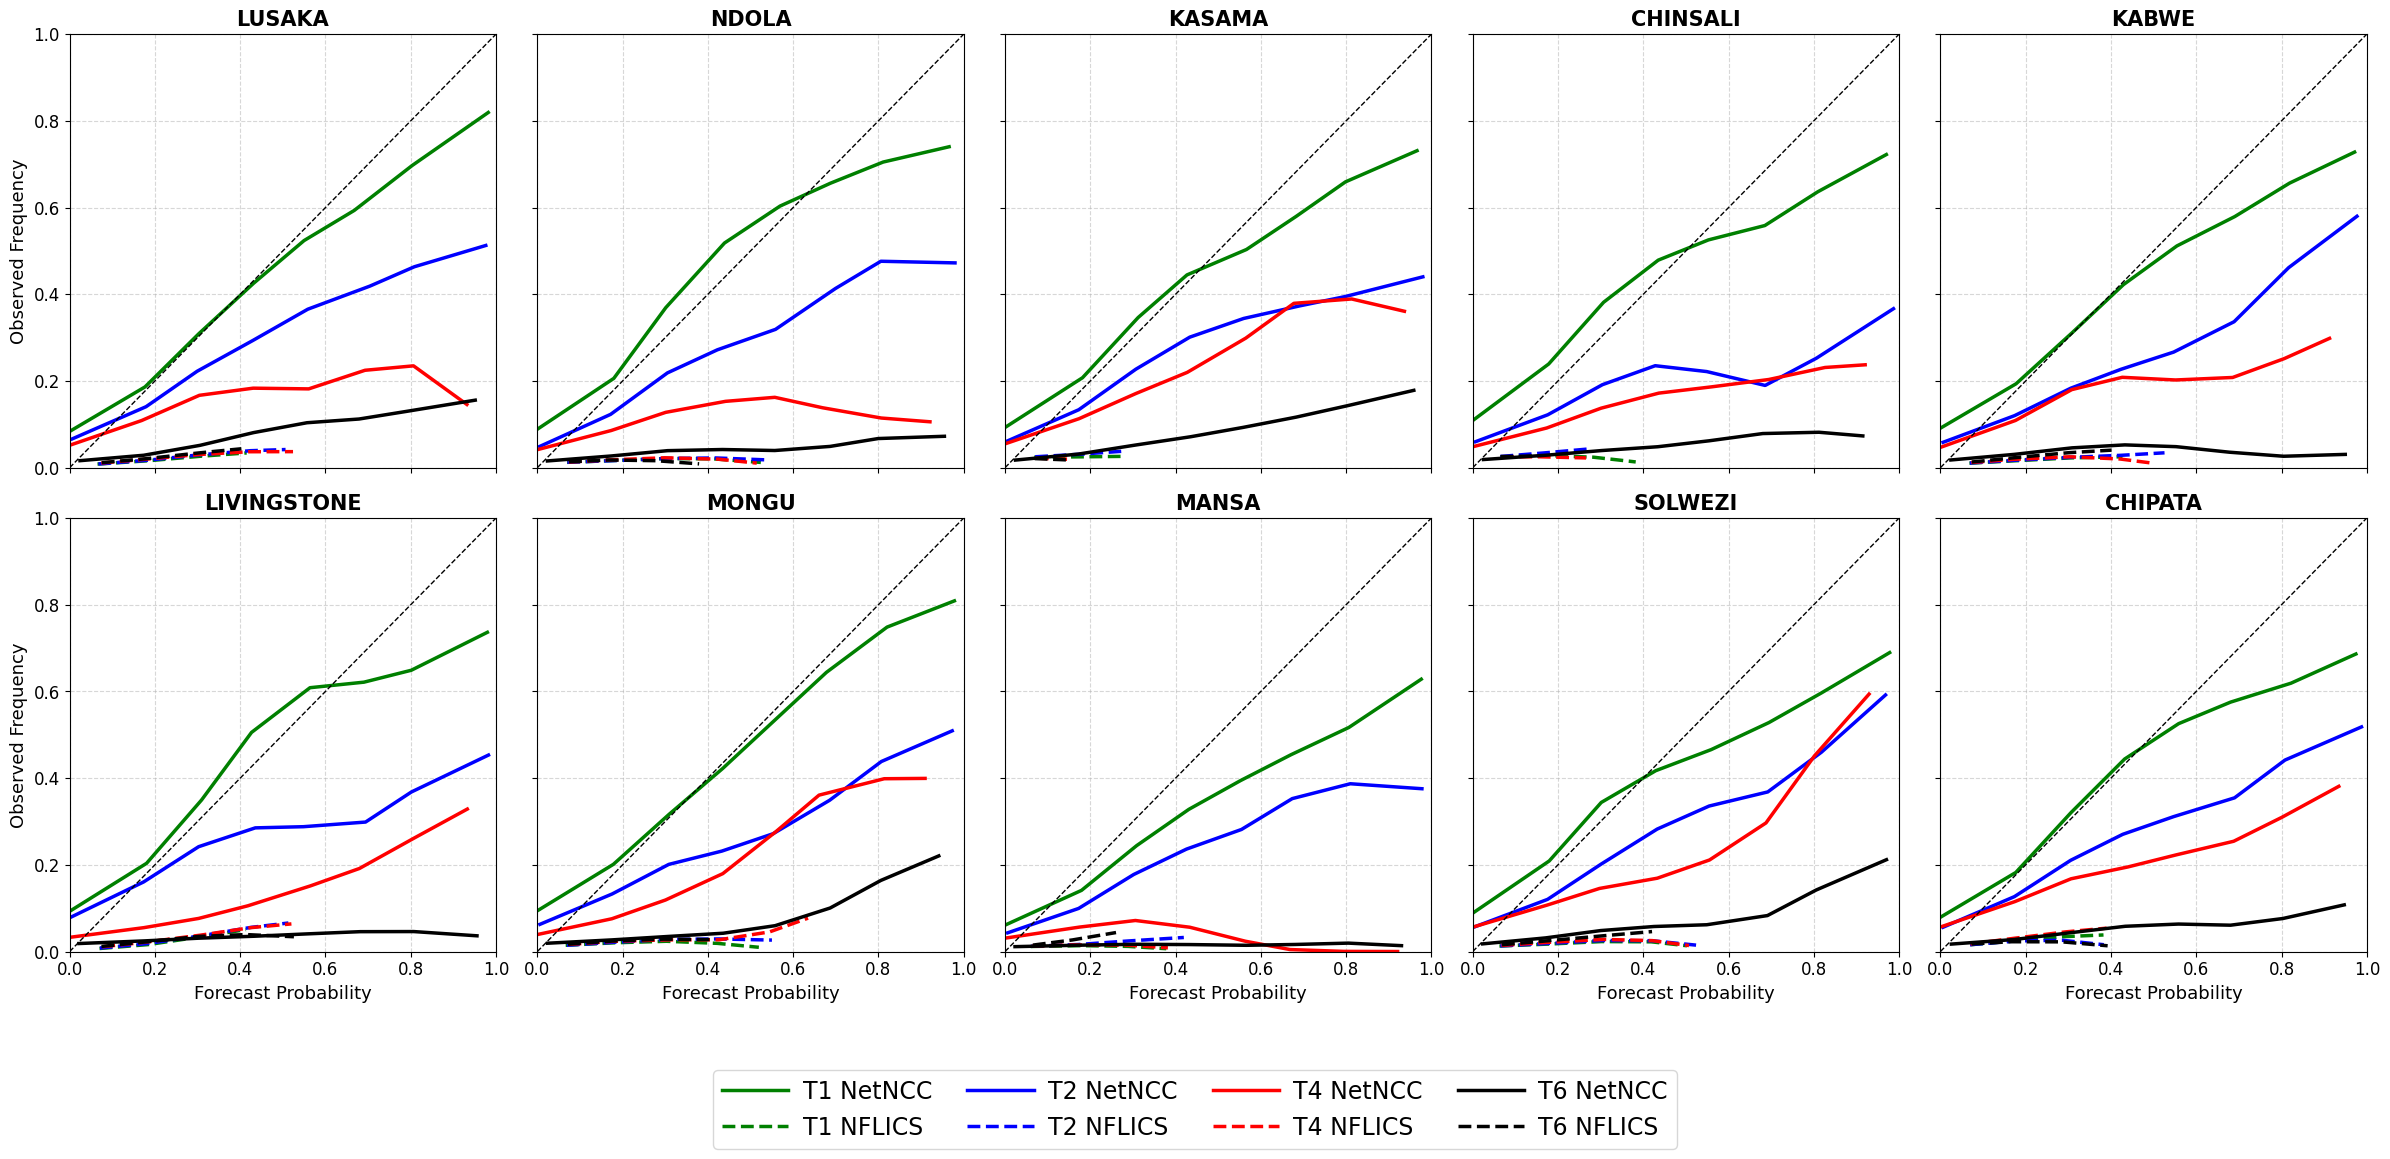

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(24, 11))
axes = axes.flatten()

colors = {"t1": "green", "t2": "blue", "t4": "red", "t6": "black"}
handles_all, labels_all = [], []

for i, city in enumerate(cities[:10]):
    ax = axes[i]
    drawn = False

    for lt in lead_times:
        df_nf = nflics[lt]
        df_nc = netncc[lt]
        gt_col = f"{city}_gt_lt{lt[-1]}"
        if gt_col not in df_nf.columns or f"{city}_{lt}" not in df_nc.columns:
            continue

        merged = pd.merge(
            df_nf[["t0", gt_col, f"{city}_{lt}"]],
            df_nc[["t0", f"{city}_{lt}"]],
            on="t0",
            suffixes=("_nfl", "_ncc")
        )

        y_true = merged[gt_col]
        y_pred_nflics = merged[f"{city}_{lt}_nfl"].replace(-998.0, np.nan)
        y_pred_netncc = merged[f"{city}_{lt}_ncc"].replace(-998.0, np.nan)

        # Convert to probability if needed
        if y_pred_netncc.max() > 1:
            y_pred_netncc /= 100.0
        if y_pred_nflics.max() > 1:
            y_pred_nflics /= 100.0

        y_pred_nflics = y_pred_nflics.clip(0, 1)
        y_pred_netncc = y_pred_netncc.clip(0, 1)

        mask_nf = ~y_pred_nflics.isna()
        mask_nc = ~y_pred_netncc.isna()
        if mask_nf.sum() < 30 or mask_nc.sum() < 30:
            continue

        # Fixed uniform bins to avoid empty output
        n_bins = 8
        prob_true_ncc, prob_pred_ncc = calibration_curve(
            y_true[mask_nc], y_pred_netncc[mask_nc], n_bins=n_bins, strategy="uniform"
        )
        prob_true_nfl, prob_pred_nfl = calibration_curve(
            y_true[mask_nf], y_pred_nflics[mask_nf], n_bins=n_bins, strategy="uniform"
        )

        # Ensure arrays align with bins; smooth slightly for clarity
        prob_true_ncc = gaussian_filter1d(prob_true_ncc, sigma=1)
        prob_true_nfl = gaussian_filter1d(prob_true_nfl, sigma=1)

        # Plot
        l1, = ax.plot(prob_pred_ncc, prob_true_ncc, color=colors[lt], lw=2.5, ls="-")
        l2, = ax.plot(prob_pred_nfl, prob_true_nfl, color=colors[lt], lw=2.5, ls="--")
        drawn = True

        if i == 0:
            handles_all.extend([l1, l2])
            labels_all.extend([f"{lt.upper()} NetNCC", f"{lt.upper()} NFLICS"])

    # Perfect calibration line
    ax.plot([0, 1], [0, 1], "k--", lw=1)
    ax.set_title(city.upper(), fontsize=15, weight="bold")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.tick_params(axis="both", labelsize=12)

    # Label placement
    if i >= 5:
        ax.set_xlabel("Forecast Probability", fontsize=13)
    else:
        ax.set_xlabel("")
        ax.set_xticklabels([])

    if i % 5 == 0:
        ax.set_ylabel("Observed Frequency", fontsize=13)
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])

    if not drawn:
        ax.text(0.5, 0.5, "No valid data", ha="center", va="center",
                fontsize=12, color="grey")

plt.subplots_adjust(hspace=0.45, wspace=0.25)

# ---------------------------------------------------------------------
# Legend
# ---------------------------------------------------------------------
fig.legend(
    handles_all,
    labels_all,
    loc="lower center",
    fontsize=17,
    frameon=True,
    facecolor="white",
    framealpha=0.9,
    edgecolor="lightgrey",
    ncol=4,
    handlelength=2.8,
    handletextpad=0.6,
    columnspacing=1.5,
    bbox_to_anchor=(0.5, -0.06)
)

plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.show()


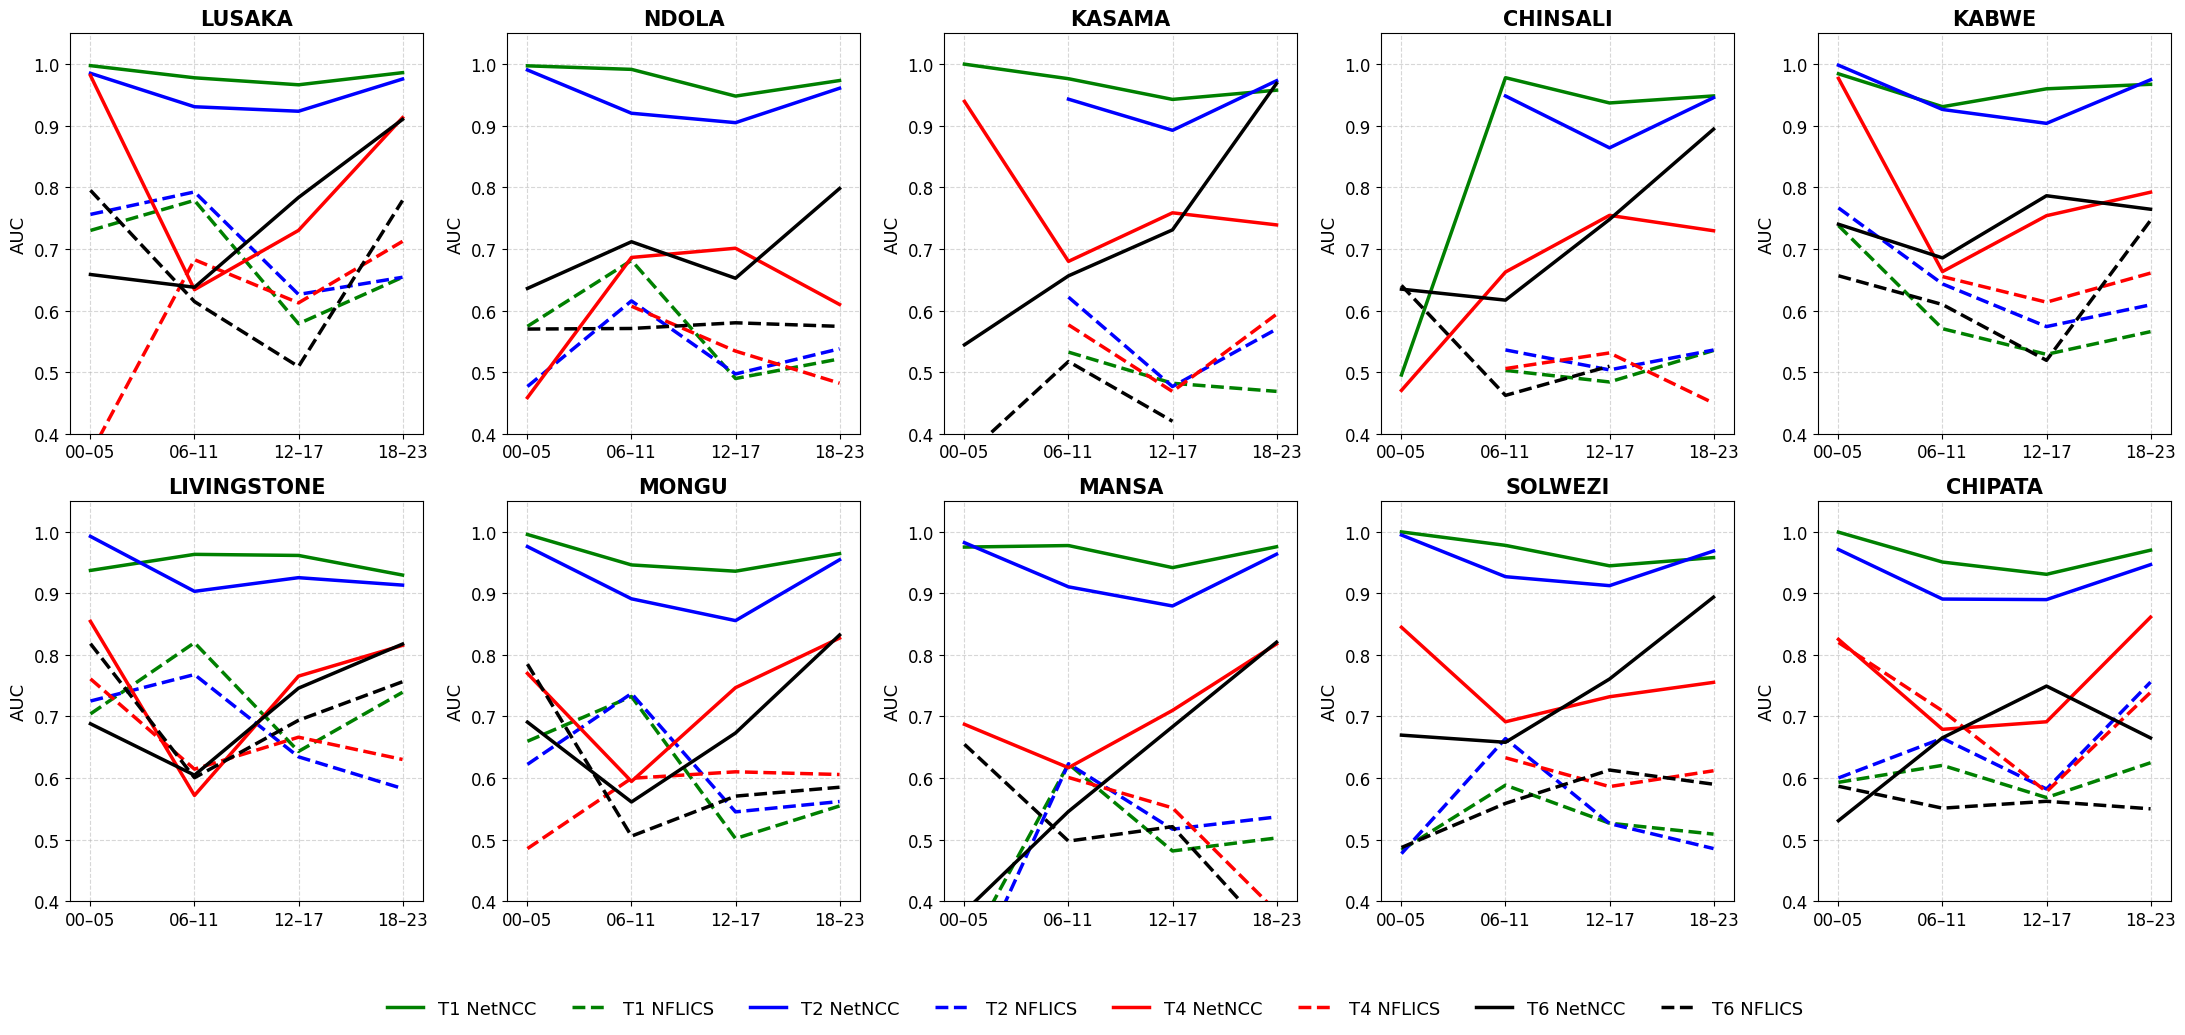

In [ ]:
def merge_all_leads(model_data, model_name):
    df_list = []
    for lt, df in model_data.items():
        df = df.copy()
        df["lead_time"] = lt
        df["model"] = model_name
        df["t0"] = pd.to_datetime(df["t0"])
        df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

df_nflics = merge_all_leads(nflics, "NFLICS")
df_netncc = merge_all_leads(netncc, "NetNCC")

# ---------------------------------------------------------------------
# Define 4 time windows
# ---------------------------------------------------------------------
def time_window(hour):
    if 0 <= hour < 6:
        return "00–05"
    elif 6 <= hour < 12:
        return "06–11"
    elif 12 <= hour < 18:
        return "12–17"
    else:
        return "18–23"

# ---------------------------------------------------------------------
# Compute mean AUC for each city / model / lead_time / window
# ---------------------------------------------------------------------
results = []
for city in cities:
    for model_name, df_model in [("NFLICS", df_nflics), ("NetNCC", df_netncc)]:
        for lt in lead_times:
            gt_col = f"{city}_gt_lt{lt[-1]}"
            pred_col = f"{city}_{lt}"
            if gt_col not in df_model.columns:
                continue

            df_sub = df_model[["t0", gt_col, pred_col]].copy()
            df_sub = df_sub.rename(columns={gt_col: "gt", pred_col: "pred"})
            df_sub["pred"] = df_sub["pred"].replace(-998.0, np.nan)
            df_sub = df_sub.dropna()
            df_sub["window"] = df_sub["t0"].dt.hour.apply(time_window)

            for w, group in df_sub.groupby("window"):
                if group["gt"].nunique() < 2:
                    continue
                auc_val = roc_auc_score(group["gt"], group["pred"])
                results.append({
                    "city": city,
                    "model": model_name,
                    "lead_time": lt,
                    "window": w,
                    "auc": auc_val
                })

auc_df = pd.DataFrame(results)
windows = ["00–05", "06–11", "12–17", "18–23"]

# ---------------------------------------------------------------------
# Plot AUC vs time window (same style as before)
# ---------------------------------------------------------------------
fig, axes = plt.subplots(2, 5, figsize=(22, 10))
axes = axes.flatten()

colors = {"t1": "green", "t2": "blue", "t4": "red", "t6": "black"}

for i, city in enumerate(cities[:10]):
    ax = axes[i]
    sub = auc_df[auc_df["city"] == city]
    if sub.empty:
        continue

    for lt in lead_times:
        for model, linestyle in [("NetNCC", "-"), ("NFLICS", "--")]:
            df_f = sub[(sub["model"] == model) & (sub["lead_time"] == lt)]
            if df_f.empty:
                continue
            df_f = df_f.set_index("window").reindex(windows)
            label = f"{lt.upper()} {model}"
            ax.plot(np.arange(len(windows)), df_f["auc"], color=colors[lt], lw=2.5, ls=linestyle, label=label)

    ax.set_title(city.upper(), fontsize=15, weight="bold")
    ax.set_xticks(np.arange(len(windows)))
    ax.set_xticklabels(windows, fontsize=12)
    ax.set_xlim([-0.2, len(windows) - 0.8])
    ax.set_ylim([0.4, 1.05])
    ax.set_ylabel("AUC", fontsize=13)
    ax.tick_params(axis="y", labelsize=12)
    ax.grid(True, linestyle="--", alpha=0.5)

plt.subplots_adjust(hspace=0.4, wspace=0.25)

# ---------------------------------------------------------------------
# Horizontal legend below all subplots
# ---------------------------------------------------------------------
handles = []
for lt in lead_times:
    for model, linestyle in [("NetNCC", "-"), ("NFLICS", "--")]:
        handles.append(
            plt.Line2D([0], [0], color=colors[lt], lw=2.5, ls=linestyle, label=f"{lt.upper()} {model}")
        )

fig.legend(
    handles=handles,
    loc="lower center",
    fontsize=13,
    frameon=False,
    ncol=8,
    bbox_to_anchor=(0.5, -0.04)
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


In [76]:
# ---------------------------------------------------------------------
# Compute Brier Skill Score (NetNCC vs NFLICS) per city / lead_time / window
# ---------------------------------------------------------------------
results = []
for city in cities:
    for lt in lead_times:
        gt_col = f"{city}_gt_lt{lt[-1]}"
        pred_col = f"{city}_{lt}"
        if gt_col not in df_nflics.columns or gt_col not in df_netncc.columns:
            continue

        df_nf = df_nflics[["t0", gt_col, pred_col]].copy()
        df_nc = df_netncc[["t0", gt_col, pred_col]].copy()

        df_nf = df_nf.rename(columns={gt_col: "gt", pred_col: "pred_nf"})
        df_nc = df_nc.rename(columns={gt_col: "gt", pred_col: "pred_nc"})

        # Merge and clean
        df_merge = pd.merge(df_nf, df_nc, on=["t0", "gt"])
        df_merge["pred_nf"] = df_merge["pred_nf"].replace(-998.0, np.nan)
        df_merge["pred_nc"] = df_merge["pred_nc"].replace(-998.0, np.nan)
        df_merge = df_merge.dropna()

        if df_merge.empty:
            continue

        # Scale if needed
        if df_merge["pred_nf"].max() > 1:
            df_merge["pred_nf"] /= 100.0
        if df_merge["pred_nc"].max() > 1:
            df_merge["pred_nc"] /= 100.0

        # Clip to valid probability range
        df_merge["pred_nf"] = df_merge["pred_nf"].clip(0, 1)
        df_merge["pred_nc"] = df_merge["pred_nc"].clip(0, 1)

        # Assign local time window
        df_merge["window"] = df_merge["t0"].dt.hour.apply(time_window)

        for w, group in df_merge.groupby("window"):
            if group["gt"].nunique() < 2:
                continue

            p_nf = group["pred_nf"].clip(0, 1)
            p_nc = group["pred_nc"].clip(0, 1)

            bs_ref = brier_score_loss(group["gt"], p_nf)
            bs_model = brier_score_loss(group["gt"], p_nc)
            bss = 1 - bs_model / (bs_ref + 1e-12)

            results.append({
                "city": city,
                "lead_time": lt,
                "window": w,
                "bss": bss
            })

bss_df = pd.DataFrame(results)
windows = ["00–05", "06–11", "12–17", "18–23"]

# ---------------------------------------------------------------------
# Plot BSS vs time window (NetNCC vs NFLICS baseline)
# ---------------------------------------------------------------------
fig, axes = plt.subplots(2, 5, figsize=(22, 10), dpi=600)
axes = axes.flatten()

colors = {"t1": "green", "t2": "blue", "t4": "red", "t6": "black"}

for i, city in enumerate(cities[:10]):
    ax = axes[i]
    sub = bss_df[bss_df["city"] == city]
    if sub.empty:
        continue

    for lt in lead_times:
        df_f = sub[sub["lead_time"] == lt]
        if df_f.empty:
            continue
        df_f = df_f.set_index("window").reindex(windows)
        ax.plot(
            np.arange(len(windows)),
            df_f["bss"],
            color=colors[lt],
            lw=2.5,
            marker="o",
            label=f"{lt.upper()} NetNCC"
        )

    ax.axhline(0, color="k", lw=1.0, linestyle="--")
    ax.set_title(city.upper(), fontsize=15, weight="bold")
    ax.set_xticks(np.arange(len(windows)))
    ax.set_xticklabels(windows, fontsize=12)
    ax.set_xlim([-0.2, len(windows) - 0.8])
    ax.set_ylim([-1.0, 1.0])
    ax.tick_params(axis="both", labelsize=11)
    ax.grid(True, linestyle="--", alpha=0.5)

    # Only show x labels on bottom row
    if i < 5:
        ax.set_xlabel("")
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Time Window", fontsize=13)

    # Only show y labels on left column
    if i % 5 == 0:
        ax.set_ylabel("Brier Skill Score (vs NFLICS)", fontsize=13)
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])

plt.subplots_adjust(hspace=0.35, wspace=0.25)

# ---------------------------------------------------------------------
# Legend below all panels
# ---------------------------------------------------------------------
handles = [
    plt.Line2D([0], [0], color=colors[lt], lw=2.5, marker="o", label=f"{lt.upper()} NetNCC")
    for lt in lead_times
]

fig.legend(
    handles=handles,
    loc="lower center",
    fontsize=14,
    frameon=True,
    facecolor="white",
    framealpha=0.9,
    edgecolor="lightgrey",
    ncol=4,
    handlelength=2.8,
    handletextpad=0.6,
    columnspacing=1.5,
    bbox_to_anchor=(0.5, -0.01)
)

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()